In [23]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import IPython.display as display
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE = 32
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Load Data

In [42]:
load_dir = os.path.join(os.getcwd(), 'data')
df_train = pd.read_csv(load_dir + '/train.csv')
df_train['image_paths'] = load_dir + '/train/' + df_train['StudyInstanceUID'] + '.jpg'
TEST = True
if TEST:
    df_train = df_train.sample(n = df_train.shape[0] // 10).reset_index(drop=True)

train, valid = train_test_split(df_train, test_size=0.1)

In [45]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image /= 255  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    

    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x, y: (data_augmentation(x), y))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    # Load labels
    label_names = df.columns[1:-2]
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(df[label_names].values, tf.int8))

    # Pack images and labels together
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    
    if augment:
        ds = augmentation(ds)
    else:
        ds = ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [46]:
train_ds = prepare_data(train, augment=True)
valid_ds = prepare_data(valid)

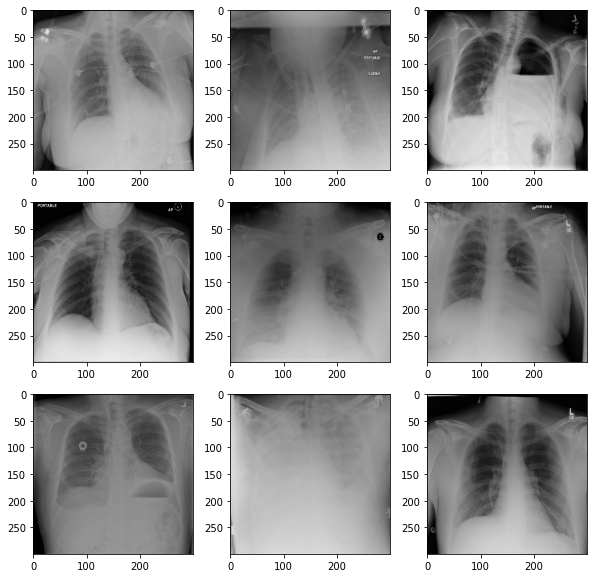

In [48]:
plt.figure(figsize=(10, 10))
for i, image, in enumerate(image_ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
plt.show()

# Model

In [49]:
def build_model(num_classes):
    """
    Build model with transfer learning
    """
    effnet = EfficientNetB0(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                            include_top=False,
                            weights='imagenet')
    effnet.trainable = False

    x = layers.GlobalAveragePooling2D()(effnet.output)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(effnet.input, x)

    # learning rate schedule
    lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, 1000, 0.1)
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['AUC']) # AUC(multi_label=True)

    return model


def train_model(model, train_ds, val_ds, save_model=True):
    callbacks = myCallback()
    history = model.fit(
        train_ds,
        epochs=10,
        #                         callbacks=[callbacks],
        validation_data=val_ds)

    if save_model:
        model.save("Kaggle_cathether_line.h5")
        print(f"Model saved")

    return history


class myCallback(tf.keras.callbacks.Callback):
    """
    Define a Callback class that stops training once accuracy reaches 97.0%
    """
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('auc') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True


def get_model_memory_usage(batch_size, model):

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum(
        [K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum(
        [K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count +
                                  trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0**3), 3) + internal_model_mem_count

    print('{} GB memory is required to train the model'.format(gbytes))

In [50]:
# input_tensor = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
# x = layers.Conv2D(3, (3, 3), padding='same')(input_tensor)

# pre_trained_model = DenseNet121(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
#                                 include_top=False,
#                                 weights='imagenet')

model = build_model(11)
get_model_memory_usage(BATCH_SIZE, model)

5.485 GB memory is required to train the model


In [13]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 300, 300, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 300, 300, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_2[0][0]            
_______________________________________________________________________________________

In [51]:
history = train_model(model, train_ds, val_ds)

Epoch 1/10
85/85 [==============================] - 44s 522ms/step - loss: 0.4098 - auc: 0.7829 - val_loss: 0.3054 - val_auc: 0.8583
Epoch 2/10
85/85 [==============================] - 43s 508ms/step - loss: 0.3046 - auc: 0.8530 - val_loss: 0.2865 - val_auc: 0.8625
Epoch 3/10
85/85 [==============================] - 43s 511ms/step - loss: 0.3021 - auc: 0.8563 - val_loss: 0.3025 - val_auc: 0.8595
Epoch 4/10
85/85 [==============================] - 43s 510ms/step - loss: 0.3024 - auc: 0.8553 - val_loss: 0.3064 - val_auc: 0.8517
Epoch 5/10
85/85 [==============================] - 43s 509ms/step - loss: 0.3020 - auc: 0.8563 - val_loss: 0.3104 - val_auc: 0.8532
Epoch 6/10
85/85 [==============================] - 43s 510ms/step - loss: 0.3018 - auc: 0.8562 - val_loss: 0.2823 - val_auc: 0.8647
Epoch 7/10
85/85 [==============================] - 44s 513ms/step - loss: 0.3012 - auc: 0.8573 - val_loss: 0.2967 - val_auc: 0.8568
Epoch 8/10
85/85 [==============================] - 44s 518ms/step - 

In [ ]:
tf.data.experimental.save(val_ds, './data/val_ds')
tf.data.experimental.save(test_image_ds.batch(BATCH_SIZE), './data/test_ds')

In [ ]:
df_submit = pd.read_csv(load_dir + '/sample_submission.csv')
image_paths_test = load_dir + '/test/' + df_submit['StudyInstanceUID'] + '.jpg'
test_path_ds = tf.data.Dataset.from_tensor_slices(image_paths_test)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [ ]:
model = tf.keras.models.load_model('Kaggle_cathether_line.h5')

In [ ]:
results =  model.predict(test_image_ds.batch(BATCH_SIZE))

In [ ]:
df_submit[df_submit.columns[1:]] = results
df_submit.to_csv('submission_desnet_test.csv')

In [ ]:
20 *40000 // 64